In [4]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from IPython.display import Image, display


## Scraping the Data

In [5]:
# Empty list to collect all the data of interest
All_Data =[]

#go through pages 1-30, one at a time
for i in range(1,31):
    
    res =requests.get("https://www.skinnytaste.com/page/%d/"%i)
    soup = BeautifulSoup(res.content, 'lxml')
    
    # Make a list of the articles found on the current page
    articles = soup.find_all('article')
    

    #go through each article, scrape the data we are interested in
    for article in articles:     
        
        title = article.find('h2',{'class':'title'})
        calories = article.find('span', {'class':'icon-star'})
        blue = article.find("span", {"class": "smart-points blue"})
        green = article.find("span", {"class": "smart-points green"})
        purple = article.find("span", {"class": "smart-points purple"})
        image= article.find('img', {'srcset': True})
        
        
        # Skip articles missing any of the variables above, 
        # as these will give errors when trying to convert to text/integers 
        if (blue==None or title==None or green == None or purple ==None or image == None
           or calories == None):
            continue
        else:
            title = title.text
            calories = float(calories.text)
            blue = int(blue.text)
            green = int(green.text)
            purple = int(purple.text)
            summary = article.find('p', {'class':'excerpt'}).text
            image= image.get('src')
            
            ## List of recipe keys: [index]=key: 
            ## [0]=Vegetarian, [1]= Under 30 minutes, [2]= Paleo, [3]= Low Carb, [4]=Dairy Free
            ## [5]= whole 30 Recipes, [6]= Air Fryer Recipes, [7]=Gluten Free, [8]=Freeser Meals,
            ## [9]= Slow Cooker Recipes, [10]=Kid Friendly, [11]= Pressure Cooker, [12]= Keto Recipe
            ## [13]= Meal Prep Recipes
            keys =['Vegetarian Meals', 'Under 30 Minutes', 'Paleo', 'Low Carb', 
                   'Dairy Free', 'Whole 30 Recipes', 'Air Fryer', 'Gluten Free',
                   'Freezer Meals', 'Slow Cooker Recipes','Kid Friendly', 'Pressure Cooker Recipes', 
                   'Keto Recipes','Meal Prep Recipes']
            ## Go through the different keys for each article. 
            ## If found add True to the boolean list (found_key), else False
            
            found_key=[]
            for key in keys:
                if (article.find('img', {'alt':key})):
                    found_key +=[True]
                else:
                    found_key +=[False]
                    
            # Collect all data for a single article into a list   
            single_article_data =[title, calories, blue, green, purple, summary, image]+ found_key
            
            # And append it to the list of all data
            All_Data += [single_article_data]
            
            


## Creating a Data Frame

In [6]:
## make pandas dataframe using the collected data above
df = pd.DataFrame(All_Data,columns =(['Title', 'Calories', 'Blue Point', 'Green Point', 
                                      'Purple Point','Summary', 'Image']+keys))

df.head()                
                  
                  

,Title,Calories,Blue Point,Green Point,Purple Point,Summary,Image,Vegetarian Meals,Under 30 Minutes,Paleo,...,Dairy Free,Whole 30 Recipes,Air Fryer,Gluten Free,Freezer Meals,Slow Cooker Recipes,Kid Friendly,Pressure Cooker Recipes,Keto Recipes,Meal Prep Recipes
0,Herb and Salt-Rubbed Dry Brine Turkey,225.0,0,2,0,This Herb and Salt-Rubbed Dry Brined Turkey co...,https://www.skinnytaste.com/wp-content/uploads...,False,False,False,...,False,False,False,True,False,False,True,False,True,False
1,Apple Cranberry Crumble,211.0,8,8,8,Apple Cranberry Crumble is delicious and perfe...,https://www.skinnytaste.com/wp-content/uploads...,True,False,False,...,True,False,False,True,False,False,True,False,False,False
2,Stuffed Turkey Breast with Cranberry Stuffing,484.0,9,9,9,Stuffed Turkey Breast with Cranberry Stuffing ...,https://www.skinnytaste.com/wp-content/uploads...,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,Slow Cooker Butternut Pear Soup,132.0,2,2,2,This Slow Cooker Butternut Pear Soup with a hi...,https://www.skinnytaste.com/wp-content/uploads...,True,False,False,...,True,False,False,True,True,True,False,False,False,False
4,Chicken Parmesan Rolls,259.0,5,8,5,These protein packed Chicken Parmesan Rolls (a...,https://www.skinnytaste.com/wp-content/uploads...,False,True,False,...,False,False,False,False,False,False,True,False,False,True


# Calories Distribution Visualization
### The distribution is visualized using a histagram. For better visualization a color map is used where the lighter the colors the higher percetage of recipes are within that range of Calories. 

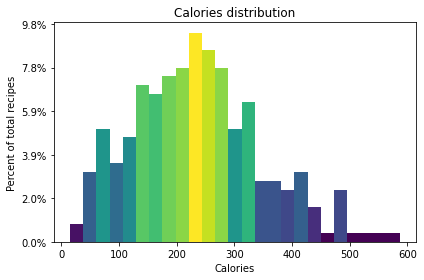

In [7]:

fig, axs = plt.subplots(1, sharey=True, tight_layout=True)

#Num =list of numbers of recipes for for each range of calories
Num, bins, patches = axs.hist(df.Calories, bins=25)
#Convert y-axix from number to precent of recipes
axs.yaxis.set_major_formatter(PercentFormatter(xmax=len(df)))
#fraction of each bin height to the max value
fracs = Num / Num.max()
norm = matplotlib.colors.Normalize(fracs.min(), fracs.max())
#set the color of the bins according to the fraction value
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
    

axs.set_title('Calories distribution')
axs.set_xlabel('Calories')
axs.set_ylabel('Percent of total recipes')

plt.show()

# Distribution of the Three Colors
### Here is visualized a table with the sum and average of the points for each of the three colors, and a barplot of color points distribution


Color points over the 30 first pages:

         Blue Points  Green Points  Purple Points
    Sum      1302.00       1566.00        1154.00
Average         5.09          6.12           4.51





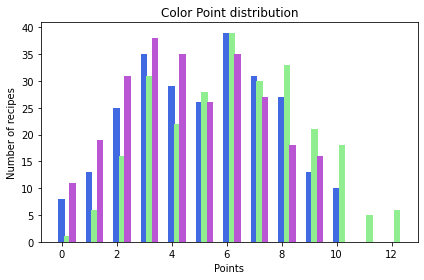

In [8]:

Points = {'Blue Points':[df['Blue Point'].sum(),round(df['Blue Point'].mean(),2)],'Green Points':[df['Green Point'].sum(), round(df['Green Point'].mean(),2)],
          'Purple Points': [df['Purple Point'].sum(), round(df['Purple Point'].mean(),2)]} 
Color_df = pd.DataFrame(Points, index = ['    Sum','Average'])


print('Color points over the 30 first pages:\n')
print(Color_df)
print('\n\n')
fig, ax = plt.subplots( sharey=True, tight_layout=True)

blue_heights, blue_bins = np.histogram(df['Blue Point'], bins = df['Blue Point'].max())
green_heights, green_bins = np.histogram(df['Green Point'], bins = df['Green Point'].max())
purple_heights, purple_bins = np.histogram(df['Purple Point'], bins = df['Purple Point'].max())
width = (blue_bins[1] - purple_bins[0])/5
ax.bar(blue_bins[:-1], blue_heights, width=.25, facecolor='Royalblue')
ax.bar(green_bins[:-1]+width, green_heights, width=.25, facecolor='lightgreen')
ax.bar(purple_bins[:-1]+width+width, purple_heights, width=.25, facecolor='Mediumorchid')
ax.set_title('Color Point distribution')
ax.set_xlabel('Points')
ax.set_ylabel('Number of recipes')
plt.show()




# Heat Map for Correlations Between Colors and Calories
### The heat map gives a value and color (0-1, light-dark) of the correlations between values of two categories. The result shows good correlations for blue points to the other colors, while a lower correlation is seen between green and purple points. 
### Calories correlates best with the green points and poorly with purple points.




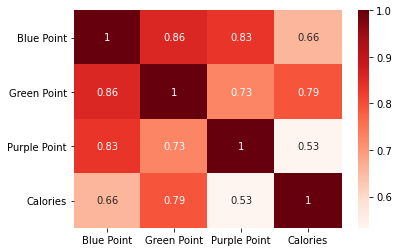

In [9]:
sns.heatmap(df[['Blue Point','Green Point', 'Purple Point', 'Calories']].corr(), annot =True, cmap ='Reds' )
plt.show()

# Distribution of keys


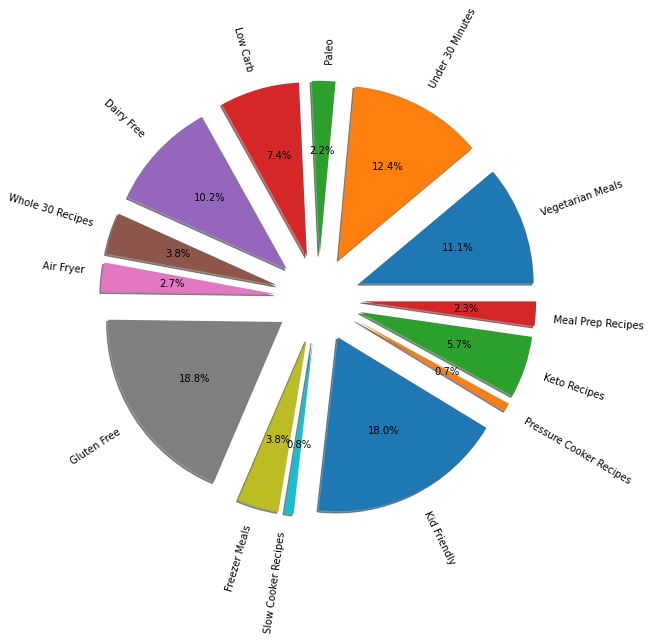

In [10]:
Total_keys=[]
expl =[]
Colors = ['gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']
for key in keys:
    Total_keys += [df[key].sum()]
    expl += [0.5]
expl = tuple(expl)
figkey, axkey = plt.subplots()
axkey.pie(Total_keys,radius=2, explode=expl, autopct="%.1f%%",labels=keys,
         shadow = True, rotatelabels = True)
plt.show()

# Recipe Search
### insert a min and max value for Calories
### Choose a color and give a min and and max value for that color point
### Choose a key (optional)

### (max) 5 recipes with the lowest calories matching the search will be visualized

In [ ]:
No_cals = True
while No_cals:
    try:
        min_calories = float(input('Minimum Calories (choose a value within 0-550): '))
        max_calories = float(input('Maximum Calories (choose a value >%d): '%(min_calories+100)))
        if (min_calories < (max_calories-99)):
            No_cals = False
        else:
            print('Please give a min value at least 100 lower than max')
    except:
        print('Please input a number')
Col_notOK = True
while (Col_notOK):
    Color = input('B = Blue, G = Green, P = Purple\n Choose a color: ').upper()
    if (Color == 'B'):
        Color = 'Blue Point'
        Col_notOK = False
    elif (Color == 'G'):
        Color = 'Green Point'
        Col_notOK = False
    elif (Color =='P'):
        Color = 'Purple Point'
        Col_notOK = False
    else:
        print('invalid character')

No_point = True
while No_point:
    try:
        Min_Point =int(input('Give the lowest acceptable point (0-13) for the chosen color: '))
        Max_Point = int(input('And the highest acceptable point: '))
        if (((Min_Point<0)or  (Max_Point<0)  or (Min_Point> 13) or (Max_Point > 13))):
            print('Please choose from the range 0-13')
        elif (Min_Point <= Max_Point):
            No_point= False
        else:
            print('the min value cannot be higher than max!')
    except:
        print('Please input numbers between 0 and 13')

ask =True
while ask:
    answer = input('Would you like to add a key to the search?\n y or n? ').lower()
    if ((answer !='y') and (answer != 'n')):
        print('Answer with y or n')
    elif answer == 'y':
        want_key= True
        ask = False
    else:
        want_key = False
        ask = False
got_key= False
if want_key:
    print('Vegetarian Meals = V, Under 30 Minutes = Q, Paleo = P, Low Carb =LC,\nDairy Free = DF, Whole 30 Recipes = W, Air Fryer = AF, Gluten Free= GF, \nFreezer Meals = FM, Slow Cooker Recipes = SC, Kid Friendly = KF, \nPressure Cooker Recipes = PC, Keto Recipes = K, Meal Prep Recipes= MP')
    
    while not(got_key):
        
        key = input ('Choose a key: ').upper()
        key_list = ['V','Q','P','LC','DF','W','AF','GF','FM','SC','KF','PC','K','MP']
        keys = ['Vegetarian Meals', 'Under 30 Minutes', 'Paleo', 'Low Carb', 
                'Dairy Free', 'Whole 30 Recipes', 'Air Fryer', 'Gluten Free',
                'Freezer Meals', 'Slow Cooker Recipes','Kid Friendly', 'Pressure Cooker Recipes', 
                'Keto Recipes','Meal Prep Recipes']
        if key in key_list:
            theKey = keys[key_list.index(key)]
            got_key= True
        else:
            print ('Invalid key')
if got_key:
    recipes = df[(df[theKey] == True) & (df['Calories'].between(min_calories,max_calories)) & (df[Color].between(Min_Point, Max_Point))]
else:
    recipes = df[(df['Calories'].between(min_calories,max_calories) & (df[Color].between(Min_Point, Max_Point)))]           
recipes =recipes.sort_values(by='Calories').reset_index(drop = True)
if (len(recipes)==0):
    print('No recipes matched your search!')
elif ((len(recipes)) < 5):
    for index in range(0, len(recipes)):
        print('--------------------------------------------------------------------------')
        print('\n')
        print("\x1b[31m"+recipes.at[index, 'Title']+"\x1b[0m")
        print('--------------------------------')
        print('Calories: '+ str(recipes.at[index, 'Calories']))
        ColPo = str(recipes.at[index,Color])
        if (Color == 'Blue Point'):
            print("\x1b[34mBlue Point:  \x1b[0m"+ColPo)
        elif (Color == 'Green Point'):
            print("\x1b[32mGreen Point:  \x1b[0m"+ ColPo)
        elif (Color == 'Purple Point'):
            print("\x1b[35mPurple Point:  \x1b[0m"+ ColPo)
        display(Image(url= recipes.at[index,'Image'], width=100, height=100))
        print(recipes.at[index,'Summary'])
        print('--------------------------------------------------------------------------')
        

else:        
    for index in range(0,5):
        print('---------------------------------------------------------------------------')
        print('\n')
        print("\x1b[31m"+recipes.at[index, 'Title']+"\x1b[0m")
        print('--------------------------------')
        print('Calories: '+ str(recipes.at[index, 'Calories']))
        ColPo = str(recipes.at[index,Color])
        if (Color == 'Blue Point'):
            print("\x1b[34mBlue Point:  \x1b[0m"+ColPo)
        elif (Color == 'Green Point'):
            print("\x1b[32mGreen Point:  \x1b[0m"+ ColPo)
        elif (Color == 'Purple Point'):
            print("\x1b[35mPurple Point:  \x1b[0m"+ ColPo)
            
        display(Image(url= recipes.at[index,'Image'], width=100, height=100))
        print(recipes.at[index,'Summary'])
        print('---------------------------------------------------------------------------')
        
    
        
          

           

Minimum Calories (choose a value within 0-550):  60
Maximum Calories (choose a value >160):  700
B = Blue, G = Green, P = Purple
 Choose a color:  g
Give the lowest acceptable point (0-13) for the chosen color:  3
And the highest acceptable point:  7
Would you like to add a key to the search?
 y or n?  y


Vegetarian Meals = V, Under 30 Minutes = Q, Paleo = P, Low Carb =LC,
Dairy Free = DF, Whole 30 Recipes = W, Air Fryer = AF, Gluten Free= GF, 
Freezer Meals = FM, Slow Cooker Recipes = SC, Kid Friendly = KF, 
Pressure Cooker Recipes = PC, Keto Recipes = K, Meal Prep Recipes= MP
